In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [19]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [23]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [24]:
# Save references to each table
# Map station class
station = Base.classes.station
# Map measurements class
measurement = Base.classes.measurement

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [26]:
# Get a list of column names and types of table measurement
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [27]:
# Find the most recent date in the data set.
most_recent_date_row = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date_row

('2017-08-23',)

One year prior: 2016-08-23


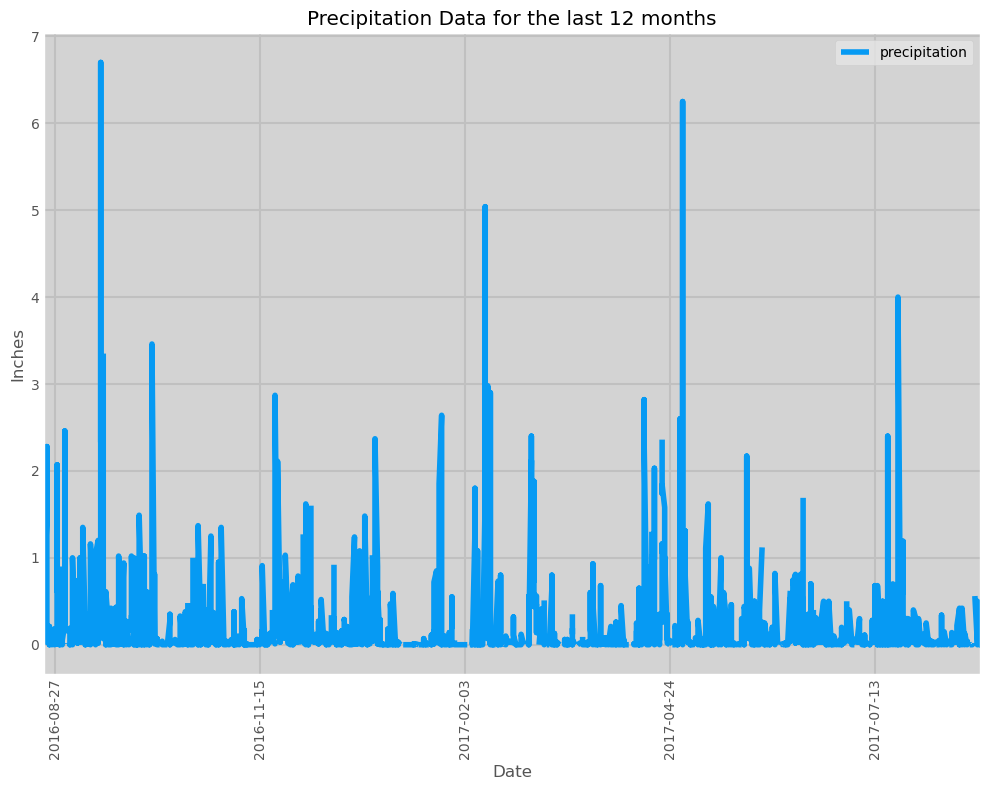

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Extract the date from the row (tuple)
most_recent_date = most_recent_date_row[0]  # This gets the first element of the tuple

# Ensure that most_recent_date is a datetime object
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the date one year from the last date in data set.
one_year_prior = most_recent_date - relativedelta(months=12)

# Convert one_year_prior to a standard datetime object
one_year_prior = one_year_prior.date()  # Convert to Python datetime

# Print to confirm the date one year prior
print("One year prior:", one_year_prior)

# Perform a query to retrieve the data and precipitation scores
measurement_one_year = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_prior).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(measurement_one_year, columns=['date', 'prcp'])

# Ensure that 'date' is a datetime object
df['date'] = pd.to_datetime(df['date'])

# Sort the DataFrame by date 
df = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,8))
plt.plot(df['date'], df['prcp'], color='#069AF3', linestyle='-', label='precipitation')
plt.title("Precipitation Data for the last 12 months")
plt.xlabel("Date")
plt.ylabel("Inches")

# Format the x-axis to show year-month-day
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

# Adjust the x-ticks to make sure they are readable
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.gca().set_facecolor('lightgray')

# Set x-ticks, y-ticks
plt.xticks(rotation='vertical')
plt.yticks(range(0, int(df['prcp'].max()) + 2, 1))

# Set x and y limits
plt.xlim(df['date'].min(), df['date'].max())
# plt.ylim(0, max(df["prcp"])+1, 1)

# Adjust layout for a tight fit
plt.style.use('ggplot')
plt.tight_layout()
plt.grid(True, color="#C0C0C0", linestyle='-', linewidth=1.5)
plt.legend()

# Show the plot
plt.show()


In [43]:
# Use Pandas to calculate the summary statistics for the precipitation data
measurement_one_year_df = pd.DataFrame(measurement_one_year)
measurement_one_year_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Get a list of column names and types of table station
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [44]:
# Design a query to calculate the total number of stations in the dataset
total= session.query(func.count(func.distinct(measurement.station))).all()
total

[(9,)]

In [41]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
for active_station, count in active_stations:
    print(f"Station: {active_station}, count: {count}")


Station: USC00519281, count: 2772
Station: USC00519397, count: 2724
Station: USC00513117, count: 2709
Station: USC00519523, count: 2669
Station: USC00516128, count: 2612
Station: USC00514830, count: 2202
Station: USC00511918, count: 1979
Station: USC00517948, count: 1372
Station: USC00518838, count: 511


In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()
print(f"The most active station: {most_active_station[0]}")
most_active_stations_info = session.query(
    func.min(measurement.tobs), 
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
    ).filter(measurement.station == most_active_station[0]).all()
print(f"The min, max, and average temperatures for the most active station: {most_active_stations_info}")

The most active station: USC00519281
The min, max, and average temperatures for the most active station: [(54.0, 85.0, 71.66378066378067)]


[('2016-08-23', 77.0), ('2016-08-24', 77.0), ('2016-08-25', 80.0), ('2016-08-26', 80.0), ('2016-08-27', 75.0), ('2016-08-28', 73.0), ('2016-08-29', 78.0), ('2016-08-30', 77.0), ('2016-08-31', 78.0), ('2016-09-01', 80.0), ('2016-09-02', 80.0), ('2016-09-03', 78.0), ('2016-09-04', 78.0), ('2016-09-05', 78.0), ('2016-09-06', 73.0), ('2016-09-07', 74.0), ('2016-09-08', 80.0), ('2016-09-09', 79.0), ('2016-09-10', 77.0), ('2016-09-11', 80.0), ('2016-09-12', 76.0), ('2016-09-13', 79.0), ('2016-09-14', 75.0), ('2016-09-15', 79.0), ('2016-09-16', 78.0), ('2016-09-17', 79.0), ('2016-09-18', 78.0), ('2016-09-19', 78.0), ('2016-09-20', 76.0), ('2016-09-21', 74.0), ('2016-09-22', 77.0), ('2016-09-23', 78.0), ('2016-09-24', 79.0), ('2016-09-25', 79.0), ('2016-09-26', 77.0), ('2016-09-27', 80.0), ('2016-09-28', 78.0), ('2016-09-29', 78.0), ('2016-09-30', 78.0), ('2016-10-01', 77.0), ('2016-10-02', 79.0), ('2016-10-03', 79.0), ('2016-10-04', 79.0), ('2016-10-05', 79.0), ('2016-10-06', 75.0), ('2016-10

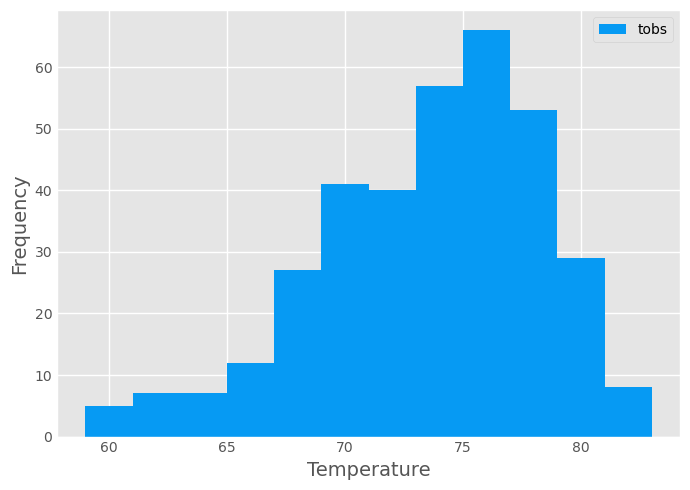

In [88]:
# Perform a query to retrieve the data and temporature
temperature_one_year = session.query(measurement.date, measurement.tobs).filter(measurement.date >= one_year_prior).filter(measurement.station ==most_active_stations[0]).all()
print(temperature_one_year)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_temperature = pd.DataFrame(temperature_one_year, columns=['date', 'tobs'])
plt.figure(figsize=(7,5))
plt.hist(df_temperature['tobs'], bins=12, color='#069AF3', label='tobs')
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Adjust layout for a tight fit
plt.style.use('ggplot')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# Close Session

In [16]:
# Close Session
session.close()